In [6]:
%pip install numpy scipy matplotlib pandas openpyxl pillow termcolor tabulate

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [7]:
import sys
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import openpyxl
from tabulate import tabulate
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from PIL import Image
from termcolor import colored, cprint

In [8]:
def prioridadErr(secuencia):
    max_consecutivos = 0
    consecutivos_actuales = 0

    for elemento in secuencia:
        if elemento == 1:
            consecutivos_actuales += 1
            max_consecutivos = max(max_consecutivos, consecutivos_actuales)
        else:
            consecutivos_actuales = 0

    return max_consecutivos
 

In [9]:
excel_dataframe = openpyxl.load_workbook("datos2_CANOPEN.xlsx")
dataframe=excel_dataframe.active
data, x_datos, y_datos = [], [], []
for row in range(1, dataframe.max_row ):
    _row= [row,]
    for col in dataframe.iter_cols(1,dataframe.max_column):
        _row.append(col[row].value)
    data.append(_row)

df = pd.DataFrame(data, columns=["Cantidad", "output", "input"])
x_datos  = df["input"].tolist()
y_datos = df["output"].tolist()

In [10]:

# x_datos = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
#                   21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40])

# y_datos = np.array([2, 4, 1, 5, 3, 7, 9, 8, 10, 12, 3, 1, 5, 2, 4, 11, 13, 12, 15, 14, 1, 3, 5, 2, 
#                     4, 17, 19, 18, 20, 22,  23, 25, 24, 27, 26,  16, 18, 20, 22, 24]) 

x_datos_ = np.copy(x_datos)
y_datos_ = np.copy(y_datos)
print(x_datos)



[0, 1514, 3048, 4632, 6199, 7741, 9321, 10866, 12514, 14148, 15750, 17395, 19008, 20540, 22138, 23781, 25162, 26694, 28280, 29925, 31485, 33066, 34631, 36200, 37805, 39373, 40936, 42757, 44110, 45734, 47335, 48965, 50539, 52154, 53815, 55412, 57046, 58640, 60258, 61889, 63469, 65092, 66694, 68094]


In [11]:
errAbsMax=0.01*np.abs(np.max(y_datos))/100 #0.01 queda
errAbsMax_Comprobar=0.2*np.abs(np.max(y_datos))/100
print(errAbsMax)
print(errAbsMax_Comprobar)

0.21400000000000002
4.28


In [12]:
minPoint=3 # +1 numero de puntos, ejemplo, si minPoint es 3, entonces evalua como minimimo 4 puntos
despValores = []
errAcumuladoAbs = []
while len(x_datos_) > minPoint:
    errAcumuladoSecuencia = []
    if minPoint < 3:
        print('***  inserte más puntos ***')
        break
    r_cuadrado = []
    for i in range(minPoint, len(x_datos_)+1):
        pendiente, intercepto, r_valor, _, _ = linregress(x_datos_[0:i], y_datos_[0:i]) # datos de la regresión lineal
        
        for ii in range(0, i):
            y_datosPredicciones=pendiente*x_datos_[ii]+intercepto # vemos el error en cada punto, el error absoluto no debe superar el 0.2%
            y_datosErr=np.abs(y_datosPredicciones-y_datos_[ii])
            if y_datosErr < errAbsMax:
                errAcumuladoAbs.append(1)
            else:
                errAcumuladoAbs.append(0)
        # print(f' hmm:{errAcumuladoAbs}')
        errAcumuladoSecuencia.append(errAcumuladoAbs) #aqui se acumula listas de listas de los errores para elegir ya que todos los R^2 aon altos
        # print(x_datos_[0:i],i, r_valor**2, )
        r_cuadrado.append(r_valor**2)
        errAcumuladoAbs = []
    
    # print(x_datos_)
    
    mejor_secuencia = max(enumerate(errAcumuladoSecuencia), key=lambda x: prioridadErr(x[1]))# Obtener la mejor secuencia y su posición
    posicion, secuencia = mejor_secuencia # Desempaquetar la tupla resultante 
    
    posicion_r2=np.argmax(r_cuadrado)+minPoint-1
    posicion = posicion+minPoint-1

    cprint(f'la secuencia es: {secuencia} --------', 'black', 'on_yellow', attrs=[ "blink"])
    print("secuencia está en la posición:", posicion, "----------------------------")
    print("el mejor r2 está en la posición:", posicion_r2, "----------------------------")

    # if np.max(r_cuadrado)>0.99:
    #     if posicion_r2>posicion:
    #         posicionFinal=posicion
    #     else:
    #         posicionFinal=posicion_r2
    if posicion_r2<posicion:
        posicionFinal=posicion_r2
    else:
        posicionFinal=posicion
    # print(np.max(r_cuadrado),posicion_r2 ,posicion, posicionFinal)   
    despValores.append(posicionFinal)
    despValores_=despValores[-1]
    x_datos_ = np.roll(x_datos_, shift=-despValores_)[:len(x_datos_)-despValores_] #desplazamiento de valores copiados x
    y_datos_ = np.roll(y_datos_, shift=-despValores_)[:len(y_datos_)-despValores_] #desplazamiento de valores copiados y 
    if 1<len(x_datos_) <= minPoint  :
        despValores.append(len(x_datos_))
        break
        
    
    

la secuencia es: [0, 0, 0, 1, 1, 0, 0] --------
secuencia está en la posición: 6 ----------------------------
el mejor r2 está en la posición: 2 ----------------------------
la secuencia es: [1, 1, 1] --------
secuencia está en la posición: 2 ----------------------------
el mejor r2 está en la posición: 2 ----------------------------
la secuencia es: [0, 1, 0, 0, 0, 1, 1, 0] --------
secuencia está en la posición: 7 ----------------------------
el mejor r2 está en la posición: 3 ----------------------------
la secuencia es: [1, 1, 1] --------
secuencia está en la posición: 2 ----------------------------
el mejor r2 está en la posición: 2 ----------------------------
la secuencia es: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0] --------
secuencia está en la posición: 15 ----------------------------
el mejor r2 está en la posición: 3 ----------------------------
la secuencia es: [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0] --------
secuencia está en la posición: 13 --------------------

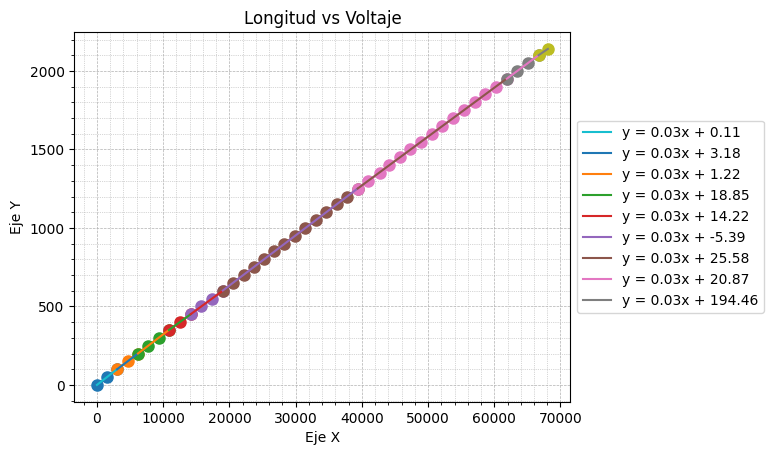

In [13]:
x_Nuevo = []
y_Nuevo = []
m_val_ = [] 
b_val_ = []

for i in range(len(despValores)):
    if i==0 :
        despMin=0
        despMax=despValores[i]
    else:
        despMin+=despValores[i-1]
        despMax+=despValores[i]
    _despValores_=despValores[i]
    x_Nuevo.append([])  # creamos para c ada array 
    y_Nuevo.append([])  # creamos para c ada array 
    x_Nuevo[i].append(x_datos[despMin:despMax+1]) #agregamos en el segundo [] segun su rango de min y max
    y_Nuevo[i].append(y_datos[despMin:despMax+1]) #agregamos en el segundo [] segun su rango de min y max
    m_val, b_val, r_val, p_val, std_error = linregress(x_datos[despMin:despMax+1], y_datos[despMin:despMax+1])
    m_val_.append(m_val)
    b_val_.append(b_val) 


#Grafica
fig, ax = plt.subplots()

for x, y in zip(x_Nuevo, y_Nuevo):
    ax.plot(x[0], y[0], marker='o', linestyle='-', markersize=8)
 
for m, b, i in zip(m_val_, b_val_, range(len(despValores)) ):
    x_values = np.linspace(x_Nuevo[i][0][0], x_Nuevo[i][0][-1], 2)
    y_values = m * x_values + b
    ax.plot(x_values, y_values, label=f'y = {m:.2f}x + {b:.2f}')
# print(m_val_)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Longitud vs Voltaje')
ax.set_xlabel('Eje X')
ax.set_ylabel('Eje Y')
# ax.legend() 
# ax.grid(True)
# resolucion_dpi = 1200
# plt.savefig('C:/Users/Usuario/Desktop/Proyectos/EncoderLineal/Python/LongVSVolt', dpi=resolucion_dpi)
# plt.show()
# img = Image.open('C:/Users/Usuario/Desktop/Proyectos/EncoderLineal/Python/LongVSVolt.png')
# img.show()
plt.show()

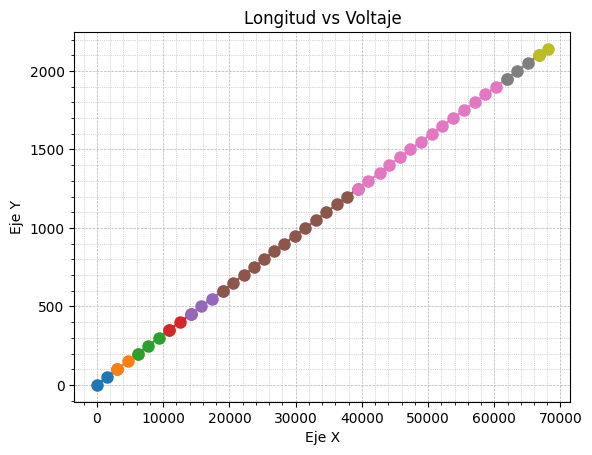

In [14]:

#Grafica
fig, ax = plt.subplots()

for x, y in zip(x_Nuevo, y_Nuevo):
    ax.plot(x[0], y[0], marker='o', linestyle='-', markersize=8)

plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth=0.5) 
ax.set_title('Longitud vs Voltaje')
ax.set_xlabel('Eje X')
ax.set_ylabel('Eje Y')
# # resolucion_dpi = 1200
# # plt.savefig('C:/Users/Usuario/Desktop/Proyectos/EncoderLineal/Python/LongVSVolt2', dpi=resolucion_dpi)
# # plt.show()
# # img = Image.open('C:/Users/Usuario/Desktop/Proyectos/EncoderLineal/Python/LongVSVolt2.png')
# # img.show()
plt.show()

[np.float64(0.03280792809466594), np.float64(0.03173564892670862), np.float64(0.03208965612249982), np.float64(0.030469041275493606), np.float64(0.030815911707218414), np.float64(0.031918112774363065), np.float64(0.03111659289164536), np.float64(0.03117516735221711), np.float64(0.02857142857142857)]


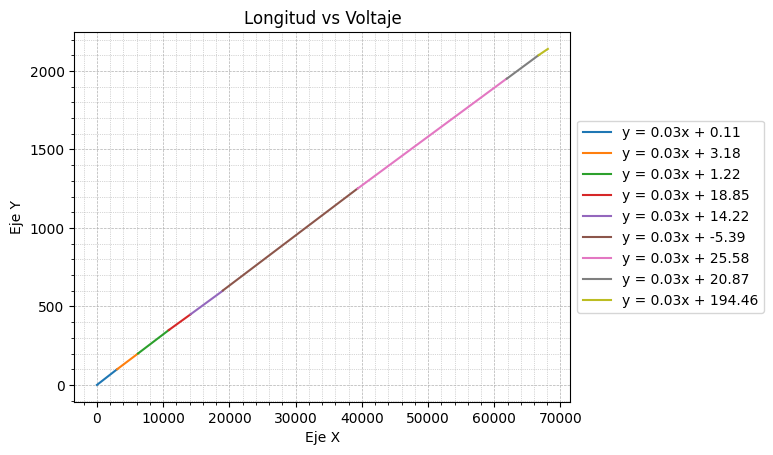

In [15]:
 
    
#Grafica
fig, ax = plt.subplots() 
for m, b, i in zip(m_val_, b_val_, range(len(despValores)) ):
    x_values = np.linspace(x_Nuevo[i][0][0], x_Nuevo[i][0][-1], 2)
    y_values = m * x_values + b
    ax.plot(x_values, y_values, label=f'y = {m:.2f}x + {b:.2f}')
print(m_val_)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Longitud vs Voltaje')
ax.set_xlabel('Eje X')
ax.set_ylabel('Eje Y')
# ax.legend() 
# ax.grid(True)
# resolucion_dpi = 1200
# plt.savefig('C:/Users/Usuario/Desktop/Proyectos/EncoderLineal/Python/LongVSVolt3', dpi=resolucion_dpi)
# plt.show()
# img = Image.open('C:/Users/Usuario/Desktop/Proyectos/EncoderLineal/Python/LongVSVolt3.png')
# img.show()




plt.show() 

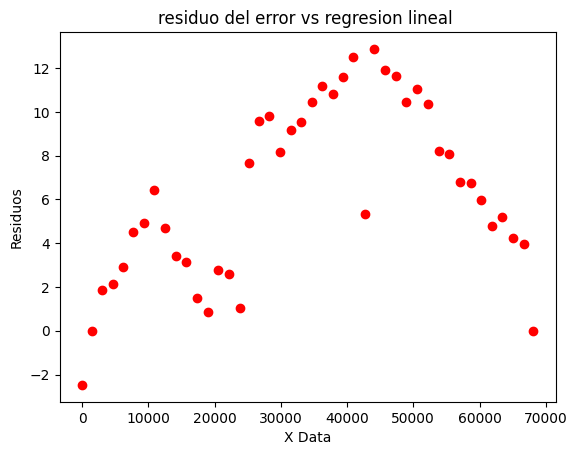

In [16]:

fig, ax = plt.subplots()


msrl = (y_datos[1] - y_datos[-1]) / (x_datos[1] - x_datos[-1])
bsrl = y_datos[1] - msrl * x_datos[1]


for i in range(len(x_datos)):
    predicted_y = msrl * x_datos[i] + bsrl
    e_values = y_datos[i] - predicted_y
    
    ax.plot(x_datos[i], e_values, marker='o', color='red')  

plt.xlabel('X Data')
plt.ylabel('Residuos')
plt.title('residuo del error vs regresion lineal ')
plt.show()

Input medido = 23781 |err = 0.17% error mayor a 0.1% | error=-3.66 mm | y= 750 | Yp = 753.659 
Input medido = 25162 |err = 0.11% error mayor a 0.1% | error=2.26 mm | y= 800 | Yp = 797.738 
Input medido = 26694 |err = 0.16% error mayor a 0.1% | error=3.36 mm | y= 850 | Yp = 846.636 
Input medido = 28280 |err = 0.13% error mayor a 0.1% | error=2.74 mm | y= 900 | Yp = 897.259 
Input medido = 42757 |err = 0.28% error mayor a 0.1% | error=-6.03 mm | y= 1350 | Yp = 1356.029 


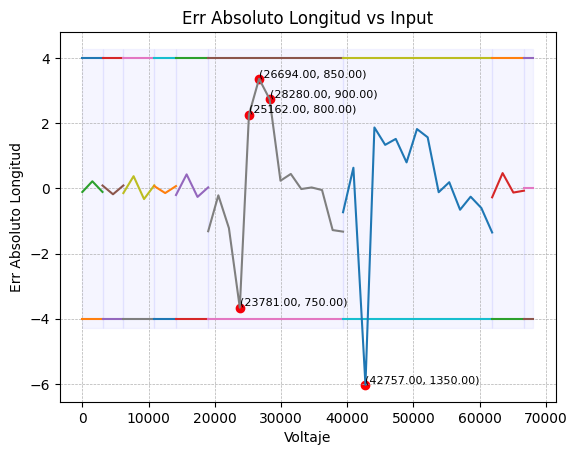

In [17]:
# errAbsMax_Comprobar=0.6
fig, ax = plt.subplots()
y1, y2 = errAbsMax_Comprobar, -errAbsMax_Comprobar
for m, b, i in zip(m_val_, b_val_, range(len(despValores))):
    x_values = np.copy(x_Nuevo[i][0][:])
    y_values_a = np.copy(y_Nuevo[i][0][:])
    y_values_p= m * x_values + b
    y_values = y_values_a - y_values_p
    for j in range(len(y_values)):
        if y_values_a[j] > 0:
            y_errValues = 100 * np.abs(y_values[j]) / np.abs(np.max(y_datos))
        else:
            y_errValues = -0.1
        if y_errValues > 0.1:
            ax.scatter(x_values[j], y_values[j], color='red') # Punto rojo en el gráfico
            ax.text(x_values[j], y_values[j], f'({x_values[j]:.2f}, {y_values_a[j]:.2f})'
                    , color='black', fontsize=8, ha='left', va='bottom') # Etiqueta para el punto rojo
            cprint(f'Input medido = {x_values[j]} |err = {y_errValues:0.2f}% error mayor a 0.1% | error={y_values[j]:0.2f} mm | y= { y_values_a[j]} | Yp = {y_values_p[j]:0.3f} ',
                   'black', 'on_yellow')
    ax.fill_between(x_values, y1, y2, color='blue', alpha=0.04)
    plt.plot(x_values, np.full_like(x_values, y1))
    plt.plot(x_values, np.full_like(x_values, y2))
    ax.plot(x_values, y_values)
ax.set_title('Err Absoluto Longitud vs Input')
ax.set_xlabel('Voltaje')
ax.set_ylabel('Err Absoluto Longitud')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show() 


In [18]:
# for i in range(len(despValores)):
#     print(x_Nuevo[i][0][0],'-------', x_Nuevo[i][0][-1])

In [19]:
vol1=1.57
for i in range(len(despValores)):
   if vol1 >=x_Nuevo[i][0][0] and vol1 < x_Nuevo[i][0][-1]:
       resol=  m_val_[i]*vol1 + b_val_[i]
       print(f'{resol:.2f}')
       break


0.16


In [20]:

#aqui es para set2
# condicional_1 = 'VarG._variations'
# condicional_2 = 'VarG._fValueNew'

# for i in range(len(despValores)):
#     if i == 0:
#         print(f"IF {condicional_1} >={x_Nuevo[i][0][0]} AND {condicional_1} < {x_Nuevo[i][0][-1]} THEN")
#         print(f"    {condicional_2} :=  {m_val_[i]}*{condicional_1} + {b_val_[i]:.3f} ;    //Recta {i+1}")
#     elif 0 < i < len(despValores) - 1:
#         print(f"ELSIF {condicional_1} >={x_Nuevo[i][0][0]} AND {condicional_1} < {x_Nuevo[i][0][-1]} THEN")
#         print(f"    {condicional_2} :=  {m_val_[i]:.7f}*{condicional_1} + {b_val_[i]:.3f} ;    //Recta {i+1}")
#     else:
#         print(f"ELSIF {condicional_1} >={x_Nuevo[i][0][0]} AND {condicional_1} <3000 THEN")
#         print(f"    {condicional_2} :=  {m_val_[i]:.7f}*{condicional_1} + {b_val_[i]:.4f} ;    //Recta {i+1}")
#         print(f"ELSE")
#         print(f"    {condicional_2} :=  0.0000 ; ")
#         print(f"END_IF")


In [ ]:
#ecuacion no lineal, hacer x=y ; y=x
condicional_1 = 'IN_VALUE'
condicional_2 = 'OUT_LONG'

for i in range(len(despValores)):
    if i == 0:
        cprint(f"IF {condicional_1} >={x_Nuevo[i][0][0]} AND {condicional_1} < {x_Nuevo[i][0][-1]} THEN", 'black', 'on_yellow', attrs=[ "blink"])
        cprint(f"    {condicional_2} :=  {m_val_[i]:.7f}*{condicional_1} + {b_val_[i]:.7f} ;    //Recta {i+1}", 'black', 'on_yellow', attrs=[ "blink"])
    elif 0 < i < len(despValores) - 1:
        cprint(f"ELSIF {condicional_1} >={x_Nuevo[i][0][0]} AND {condicional_1} < {x_Nuevo[i][0][-1]} THEN", 'black', 'on_yellow', attrs=[ "blink"])
        cprint(f"    {condicional_2} :=  {m_val_[i]:.7f}*{condicional_1} + {b_val_[i]:.7f} ;    //Recta {i+1}", 'black', 'on_yellow', attrs=[ "blink"])
    else:
        cprint(f"ELSIF {condicional_1} >={x_Nuevo[i][0][0]} AND {condicional_1} <110000 THEN", 'black', 'on_yellow', attrs=[ "blink"])
        cprint(f"    {condicional_2} :=  {m_val_[i]:.7f}*{condicional_1} + {b_val_[i]:.7f} ;    //Recta {i+1}", 'black', 'on_yellow', attrs=[ "blink"])
        cprint(f"ELSE", 'black', 'on_yellow', attrs=[ "blink"])
        cprint(f"    {condicional_2} :=  0.0000 ; ", 'black', 'on_yellow', attrs=[ "blink"])
        cprint(f"END_IF", 'black', 'on_yellow', attrs=[ "blink"])


IF IN_VALUE >=0 AND IN_VALUE < 3048 THEN
    OUT_LONG :=  0.0328079*IN_VALUE + 0.1100773 ;    //Recta 1
ELSIF IN_VALUE >=3048 AND IN_VALUE < 6199 THEN
    OUT_LONG :=  0.0317356*IN_VALUE + 3.1803095 ;    //Recta 2
ELSIF IN_VALUE >=6199 AND IN_VALUE < 10866 THEN
    OUT_LONG :=  0.0320897*IN_VALUE + 1.2190764 ;    //Recta 3
ELSIF IN_VALUE >=10866 AND IN_VALUE < 14148 THEN
    OUT_LONG :=  0.0304690*IN_VALUE + 18.8526063 ;    //Recta 4
ELSIF IN_VALUE >=14148 AND IN_VALUE < 19008 THEN
    OUT_LONG :=  0.0308159*IN_VALUE + 14.2185595 ;    //Recta 5
ELSIF IN_VALUE >=19008 AND IN_VALUE < 39373 THEN
    OUT_LONG :=  0.0319181*IN_VALUE + -5.3856290 ;    //Recta 6
ELSIF IN_VALUE >=39373 AND IN_VALUE < 61889 THEN
    OUT_LONG :=  0.0311166*IN_VALUE + 25.5771539 ;    //Recta 7
ELSIF IN_VALUE >=61889 AND IN_VALUE < 66694 THEN
    OUT_LONG :=  0.0311752*IN_VALUE + 20.8731916 ;    //Recta 8
ELSIF IN_VALUE >=66694 AND IN_VALUE <110000 THEN
    OUT_LONG :=  0.0285714*IN_VALUE + 194.4571429 ;    //Rect

: 